<a href="https://colab.research.google.com/github/maryvirabyan/ACA/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np

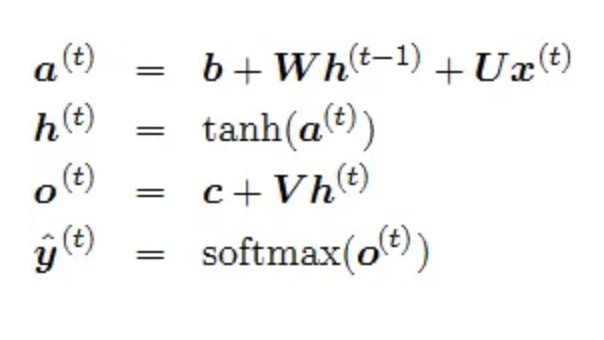

In [13]:
import numpy as np

class VanillaRNN:
    def __init__(self, data_file, hidden_size=100, seq_length=25, learning_rate=1e-1):
        self.data = open(data_file, 'r').read()
        self.chars = list(set(self.data))
        self.data_size, self.vocab_size = len(self.data), len(self.chars)
        self.char_to_ix = {ch: i for i, ch in enumerate(self.chars)}
        self.ix_to_char = {i: ch for i, ch in enumerate(self.chars)}
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        self.Wxh = np.random.randn(self.hidden_size, self.vocab_size) * 0.01
        self.Whh = np.random.randn(self.hidden_size, self.hidden_size) * 0.01
        self.Why = np.random.randn(self.vocab_size, self.hidden_size) * 0.01
        self.bh = np.zeros((self.hidden_size, 1))
        self.by = np.zeros((self.vocab_size, 1))
        self.n, self.p = 0, 0
        self.mWxh, self.mWhh, self.mWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        #adagradi memorynery
        self.mbh, self.mby = np.zeros_like(self.bh), np.zeros_like(self.by)

    def lossFun(self, inputs, targets, hprev):
        xs, hs, ys, ps = {}, {}, {}, {}
        hs[-1] = np.copy(hprev)
        loss = 0
        for t in range(len(inputs)):
            xs[t] = np.zeros((self.vocab_size, 1))
            xs[t][inputs[t]] = 1
            hs[t] = np.tanh(np.dot(self.Wxh, xs[t]) + np.dot(self.Whh, hs[t-1]) + self.bh)
            ys[t] = np.dot(self.Why, hs[t]) + self.by
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
            loss += -np.log(ps[t][targets[t], 0])
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(hs[0])
        for t in reversed(range(len(inputs))):
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1
            dWhy += np.dot(dy, hs[t].T)
            dby += dy
            dh = np.dot(self.Why.T, dy) + dhnext
            dhraw = (1 - hs[t] * hs[t]) * dh
            dbh += dhraw
            dWxh += np.dot(dhraw, xs[t].T)
            dWhh += np.dot(dhraw, hs[t-1].T)
            dhnext = np.dot(self.Whh.T, dhraw)
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)
        return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

    def sample(self, h, seed_ix, n):
      ixes = []
      x = np.zeros((self.vocab_size, 1))
      x[seed_ix] = 1
      for _ in range(n):
          h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
          y = np.dot(self.Why, h) + self.by
          p = np.exp(y) / np.sum(np.exp(y))
          ix = np.random.choice(self.vocab_size, p=p.ravel())
          x.fill(0)
          x[ix] = 1
          ixes.append(ix)
      return ixes

    def train(self):
        while True:
            if self.p + self.seq_length + 1 >= len(self.data) or self.n == 0:
                hprev = np.zeros((self.hidden_size, 1))
                self.p = 0
            inputs = [self.char_to_ix[ch] for ch in self.data[self.p:self.p+self.seq_length]]
            targets = [self.char_to_ix[ch] for ch in self.data[self.p+1:self.p+self.seq_length+1]]
            if self.n % 100 == 0:
                sample_ix = self.sample(hprev, inputs[0], 200)
                txt = ''.join(self.ix_to_char[ix] for ix in sample_ix)
                print('----\n%s\n----' % (txt,))
            loss, dWxh, dWhh, dWhy, dbh, dby, hprev = self.lossFun(inputs, targets, hprev)
            if self.n % 100 == 0:
                print ('iter %d, loss: %f' % (self.n, loss))
            for param, dparam, mem in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by],
                                          [dWxh, dWhh, dWhy, dbh, dby],
                                          [self.mWxh, self.mWhh, self.mWhy, self.mbh, self.mby]):
                mem += dparam * dparam
                param += -self.learning_rate * dparam / np.sqrt(mem + 1e-8)

            self.p += self.seq_length
            self.n += 1


In [14]:
model = VanillaRNN("input.txt")
model.train()

----
yiPqKHq{jzuSVV'C1wcHNY{\JVxv(E{I490Yj("f2VZraiNQTY5uesK~8Y	amMUBFIm
J6D1QL:iHONyzwLHS~uc"kxUs~YTIRNi	Vkg ccybncE:sal"7fDSV?l mo:AX6qJ"o,i3Q9npF-*t0 qaNg7bg'O\8yOZoHPD0 2 p-d"HUIj\qY;K"s'V0:c\PyJ{CYWXE
----
iter 0, loss: 109.856618
----
  h sMM  Du   fhP. e ,nnn bah dhsMdh  cD ususs hlrcee nehs r Mhe Mn ss\DeoeMs y
h .eg  u
fdp cuy une 
hhuMes
  nule  DDgsh,,f,
  nh ulttrchrhe
h
nr rMsa cMssersrsnMs.heh,l   aT r e hhad 
h shsnht
df h
----
iter 100, loss: 77.479583
----
  d veahtonnd tddvn d an bm.nor wnlnhs  vs t r guir-n. attedtvsM nattnrm. t .h
' .hlkutsnartMom.dt dm o sDo . lnt e u. \rug,dr. n Mes Ht  
r.sen l tmrnuhndMudkoM  m -n l  \a   t g s rsn Dn tmtp.ammt t
----
iter 200, loss: 81.281471
----
Me d
Me ky uevD\ls
hiwel
rt

vfkrl
elWd  e s
Dh
ddt- ef
lana s.\\ m tlyO. rt
blllE".
ailii bphe ohord Meueuelklla\ nre eh
jes aghe\ ao rf th
wa. uay le doulrrelornleMwuoa
ah
f t
tkivl.k\rooee i hpukl 
----
iter 300, loss: 76.065638
----
 tus gat toe nhas vethece"ry's.gr"d.y ue sxoffao

KeyboardInterrupt: ignored